<a href="https://colab.research.google.com/github/er-mukeshmahato/Adafruit_SSD1306/blob/master/Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Upload kaggle.json (your Kaggle API token)


In [13]:
from google.colab import files
files.upload()  # Upload kaggle.json file here when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mukeshmahato1122","key":"79e16915a31ef978d4ff90118f80a710"}'}

# Step 2: Setup Kaggle credentials and install kaggle CLI

In [14]:
import os
import shutil

# Setup kaggle credentials
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

# Step 3: Download dataset from Kaggle

In [15]:

!kaggle datasets download -d pranavgautam29/chest-x-ray-imagesmultiple-diseases



Dataset URL: https://www.kaggle.com/datasets/pranavgautam29/chest-x-ray-imagesmultiple-diseases
License(s): apache-2.0
chest-x-ray-imagesmultiple-diseases.zip: Skipping, found more recently modified local copy (use --force to force download)


# Step 4: Verify and unzip the dataset

In [16]:

!unzip -o -q /content/chest-x-ray-imagesmultiple-diseases.zip -d /content/data


# Step 5: Import libraries and set parameters

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

data_dir = "/content/data/data"  # Path inside unzipped folder; adjust if necessary
batch_size = 32
img_height = 224
img_width = 224
epochs = 10


# Step 6: Load dataset with training and validation splits

In [18]:

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes found:", class_names)

Found 4452 files belonging to 5 classes.
Using 3562 files for training.
Found 4452 files belonging to 5 classes.
Using 890 files for validation.
Classes found: ['Covid', 'Normal', 'Pneumonia', 'Pneumothorax', 'Tuberculosis']


In [19]:
# Step 7: Define data augmentation and prepare datasets

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Step 8: Build model using EfficientNetB0 with transfer learning

In [21]:
# Rebuild the model with improved dropout and fine-tuning
base_model = tf.keras.applications.DenseNet121(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True  # Enable fine-tuning

# Freeze all layers except top 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Model architecture
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)  # Increased dropout to reduce overfitting
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,042,629 (26.87 MB)

 Trainable params: 372,293 (1.42 MB)

 Non-trainable params: 6,670,336 (25.45 MB)

# Step 9: Train model with EarlyStopping and ModelCheckpoint callbacks



In [22]:
checkpoint_path = "refined_best_model.keras"
cb = [
    callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
    callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb
)

model.save("refined_final_model.keras")
print("Refined model saved.")


Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 75s 307ms/step - accuracy: 0.3447 - loss: 1.7685 - val_accuracy: 0.5854 - val_loss: 1.0285
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.5319 - loss: 1.2177 - val_accuracy: 0.6101 - val_loss: 0.8739
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - accuracy: 0.6117 - loss: 0.9652 - val_accuracy: 0.6719 - val_loss: 0.7698
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.6520 - loss: 0.9134 - val_accuracy: 0.6989 - val_loss: 0.7047
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.6737 - loss: 0.8217 - val_accuracy: 0.7079 - val_loss: 0.6617
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - accuracy: 0.7105 - loss: 0.7304 - val_accuracy: 0.7427 - val_loss: 0.5959
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.7340 - loss: 0.7081 - val_accuracy: 0.7191 - val_loss: 0.6268
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 0.7590 - loss: 0

# Step 10: Plot training & validation accuracy and loss graphs

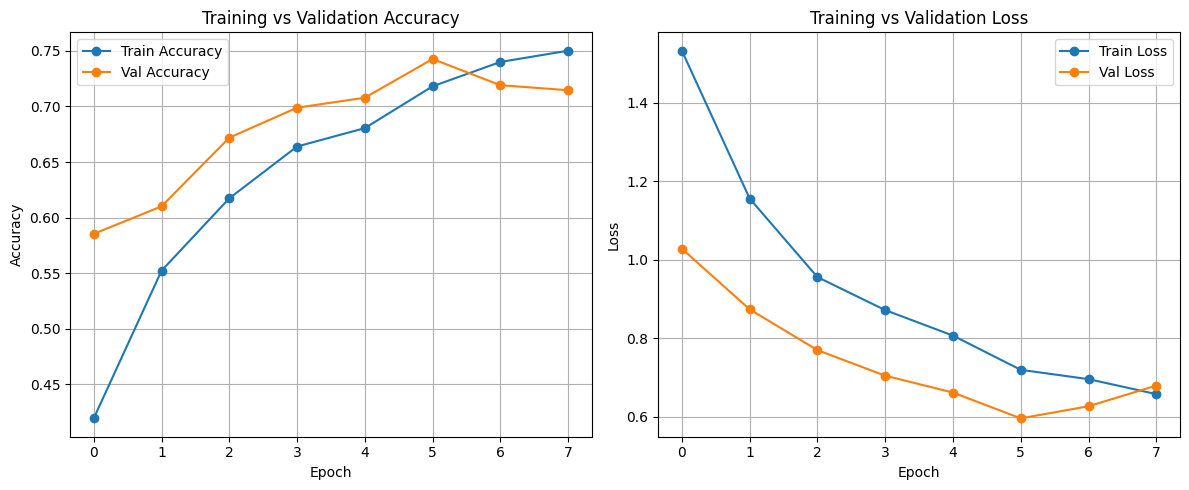

In [23]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Val Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


What you can do next:
Fine-tune the model:
Unfreeze some top DenseNet layers to improve feature extraction on your dataset.

Use a lower learning rate during fine-tuning (e.g., 1e-4 or 1e-5) to avoid destroying pretrained weights.

Add stronger regularization or augmentations if validation accuracy plateaus or overfitting starts.
